# Age-prediction model by photo

## Project description.
The online supermarket "Bread-Salt" is implementing a computer vision system to process customer photos. Photo fixation in the checkout area will help to determine the age of customers in order to: analyze purchases and offer products that may interest customers of this age group; monitor the diligence of cashiers when selling alcohol. We will build a model that will determine the approximate age of a person by their photo. You have a set of photos of people with their age indicated, a dataset with an etalon mae of 5.4, and the task of obtaining a mae level on the test sample of no more than 8.

## Contents:
1. Data Reviewing, Preprocessing and EDA.
2. Model training.
3. Analysis of the model and conclusion.

## Description of data:
Dataset from ChaLearn Looking at People (http://chalearnlap.cvc.uab.es/dataset/26/description/).

We have one folder with all the images (/final_files) and a CSV file, labels.csv, with two columns: file_name and real_age.
* file_name - the name of the image file;
* real_age - the age of the person depicted.

## 1. Data Reviewing, Preprocessing and EDA.

Import the libraries and tools.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

from tensorflow.keras.layers import Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


No missing values were detected.

Let's look at the age distribution.

In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Распределение возраста'), Text(0.5, 0, 'Возраст')]

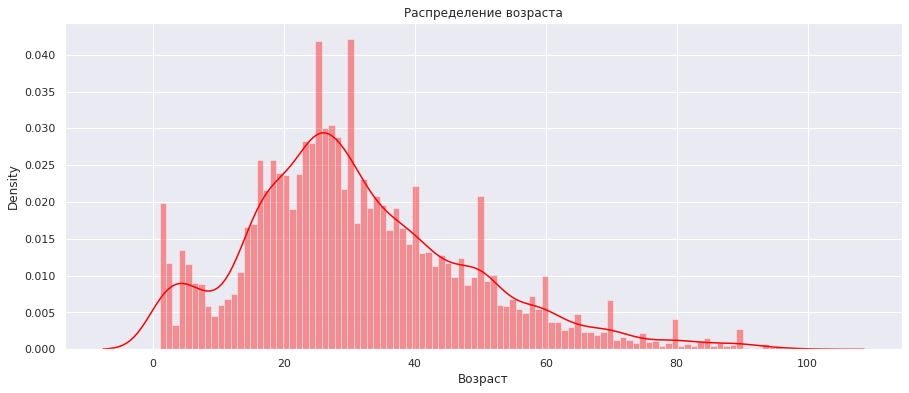

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = sns.distplot(labels['real_age'], color='red', bins=100)
ax.set(title='Age distribution', xlabel='Age')

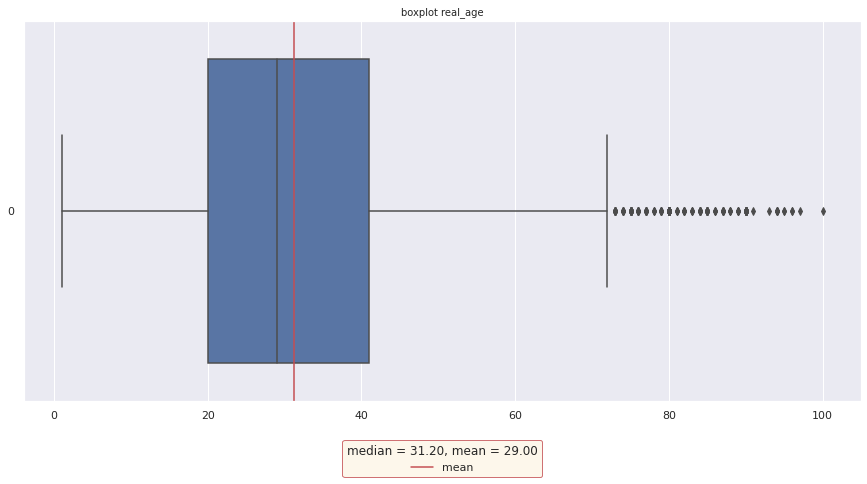

In [ ]:
plt.figure(figsize=[15, 7])
plt.title(f'boxplot real_age', fontsize=10)
sns.set_style('darkgrid')
sns.boxplot(data=labels['real_age'], orient='h')
plt.axvline(np.mean(labels['real_age']), 
            color='r', 
            linestyle='-',
            label='mean')
median = np.mean(labels['real_age'])
mean = np.median(labels['real_age'])
plt.legend(title=f'median = {median:.2f}, mean = {mean:.2f}', 
           loc='center', 
           edgecolor = 'r',
           facecolor = 'oldlace',
           bbox_to_anchor=(0.5, -0.15))

Most people are between 20 and 41 years old. Fewest are from 76 to 100. The distribution diagram shows peaks starting from 20 years and multiples of 10 years. This may be related to the data labeling system. Or the exact age was unknown and an approximate one was given.

We will select 16 photos and look at them.

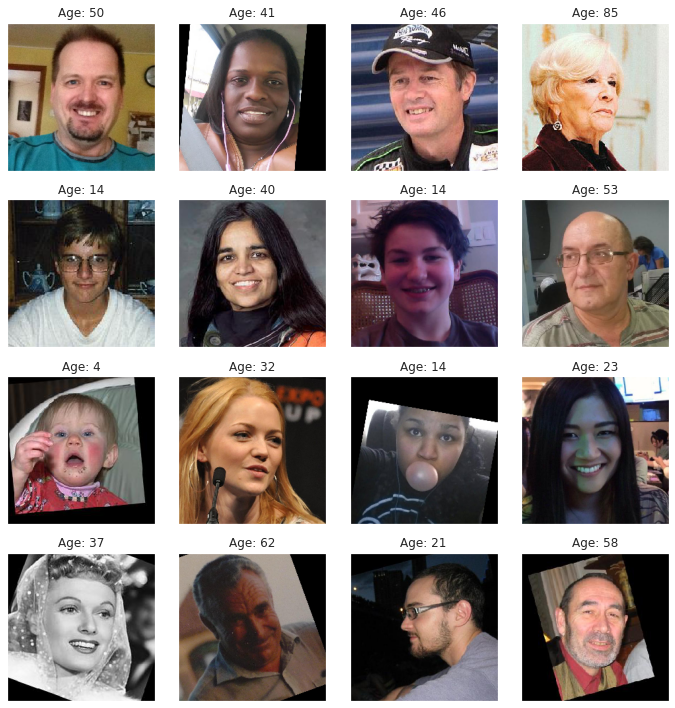

In [ ]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Age: ' + str(target[i]))

#### Conclusion:
* The sample consists of 7591 photos of different sizes;
* The set includes both color and black and white photos;
* As can be seen from the photos, the primary augmentation has already been done: some photos are distorted and shifted. Pre-augmentation is not required;
* All photos are brought to the same scale;
* The main volume of images falls on the age of 20-41 years, to a lesser extent up to 19 years and 42-100 years. This distribution may affect the accuracy of the model.

## 2. Model training.

In [ ]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae'])

    return model

def train_model(
    model, 
    train_data, 
    test_data, 
    batch_size=None, 
    epochs=15,
    steps_per_epoch=None, 
    validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)

    return model

2022-12-15 12:58:54.821884: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-12-15 12:58:54.823638: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-12-15 12:58:55.693925: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-12-15 12:58:56.370694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-12-15 12:58:56.370774: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-12-15 12:58:56.370806: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-12-15 12:58:56.372820: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-12-15 12:58:56.373208: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-12-15 12:58:56.375804: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-12-15 12:58:56.376980: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-12-15 12:58:56.377044: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-12-15 12:58:56.381718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-12-15 12:58:56.556216: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-12-15 12:58:56.562536: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-12-15 12:58:56.563127: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3e20cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-12-15 12:58:56.563155: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-12-15 12:58:56.710225: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3480fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-15 12:58:56.710264: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-12-15 12:58:56.712626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-12-15 12:58:56.712689: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-12-15 12:58:56.712699: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-12-15 12:58:56.712731: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-12-15 12:58:56.712743: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-12-15 12:58:56.712755: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-12-15 12:58:56.712766: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-12-15 12:58:56.712774: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-12-15 12:58:56.717091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-12-15 12:58:56.717156: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-12-15 12:58:57.041285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-15 12:58:57.041346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-12-15 12:58:57.041354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-12-15 12:58:57.045969: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-12-15 12:58:57.046021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 24s
   81920/94765736 [..............................] - ETA: 1:03
  262144/94765736 [..............................] - ETA: 40s 
  770048/94765736 [..............................] - ETA: 20s
 2088960/94765736 [..............................] - ETA: 10s
 5324800/94765736 [>.............................] - ETA: 4s 
 9822208/94765736 [==>...........................] - ETA: 2s
13352960/94765736 [===>..........................] - ETA: 2s
17448960/94765736 [====>.........................] - ETA: 1s
21954560/94765736 [=====>........................] - ETA: 1s
25780224/94765736 [=======>......................] - ETA: 1s
29458432/94765736 [========>.....................] - ETA: 1s
34283520/94765736 [=========>....................] - ETA: 1s
38133760/94765736 [===========>..................] - ETA: 1s
41730048/94765736 [============>.................] - ETA: 0s
46268416/94765736 [=============>................] - ETA: 0s
50593792/94765736 [===============>..............] - ETA: 0s
54009856/94765736 [================>.............] - ETA: 0s
58114048/94765736 [=================>............] - ETA: 0s
62660608/94765736 [==================>...........] - ETA: 0s
66396160/94765736 [====================>.........] - ETA: 0s
70238208/94765736 [=====================>........] - ETA: 0s
74907648/94765736 [======================>.......] - ETA: 0s
78733312/94765736 [=======================>......] - ETA: 0s
82386944/94765736 [=========================>....] - ETA: 0s
87072768/94765736 [==========================>...] - ETA: 0s
91119616/94765736 [===========================>..] - ETA: 0s
94715904/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/15
2022-12-15 12:59:09.511896: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-12-15 12:59:09.802417: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 48s - loss: 225.3233 - mae: 10.8209 - val_loss: 381.5430 - val_mae: 14.5636
Epoch 2/15
356/356 - 40s - loss: 85.1898 - mae: 6.9526 - val_loss: 143.4670 - val_mae: 9.3998
Epoch 3/15
356/356 - 44s - loss: 58.4471 - mae: 5.8309 - val_loss: 75.6022 - val_mae: 6.5419
Epoch 4/15
356/356 - 44s - loss: 40.1718 - mae: 4.8676 - val_loss: 67.8435 - val_mae: 6.1065
Epoch 5/15
356/356 - 44s - loss: 32.1991 - mae: 4.3684 - val_loss: 75.4538 - val_mae: 6.3818
Epoch 6/15
356/356 - 41s - loss: 25.2190 - mae: 3.8654 - val_loss: 85.2265 - val_mae: 7.0714
Epoch 7/15
356/356 - 44s - loss: 19.3267 - mae: 3.3644 - val_loss: 64.7127 - val_mae: 5.9479
Epoch 8/15
356/356 - 44s - loss: 15.7770 - mae: 3.0190 - val_loss: 68.4384 - val_mae: 6.2325
Epoch 9/15
356/356 - 43s - loss: 14.2023 - mae: 2.8659 - val_loss: 71.5481 - val_mae: 6.4705
Epoch 10/15
356/356 - 43s - loss: 12.1566 - mae: 2.6711 - val_loss: 66.0060 - val_mae: 6.1562
Epoch 11/15
356/356 - 43s - loss: 11.5309 - mae: 2.5846 - val_loss: 73.9939 - val_mae: 6.6630
Epoch 12/15
356/356 - 44s - loss: 12.2697 - mae: 2.6806 - val_loss: 64.4613 - val_mae: 5.9325
Epoch 13/15
356/356 - 43s - loss: 11.9896 - mae: 2.6385 - val_loss: 73.6075 - val_mae: 6.5275
Epoch 14/15
356/356 - 46s - loss: 13.1180 - mae: 2.7476 - val_loss: 67.7188 - val_mae: 6.2707
Epoch 15/15
356/356 - 66s - loss: 12.2126 - mae: 2.6487 - val_loss: 62.4167 - val_mae: 5.8618
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 62.4167 - mae: 5.8618
Test MAE: 5.8618
    
    
Epoch 1/20
2022-12-15 15:22:33.426910: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-12-15 15:22:33.801709: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 71s - loss: 244.3961 - mae: 11.3006 - val_loss: 957.7169 - val_mae: 26.2083
Epoch 2/20
356/356 - 45s - loss: 79.8629 - mae: 6.8031 - val_loss: 162.1840 - val_mae: 9.6322
Epoch 3/20
356/356 - 46s - loss: 51.2168 - mae: 5.5184 - val_loss: 77.2857 - val_mae: 6.7601
Epoch 4/20
356/356 - 45s - loss: 41.4624 - mae: 4.8873 - val_loss: 82.4432 - val_mae: 6.6512
Epoch 5/20
356/356 - 45s - loss: 32.4939 - mae: 4.3405 - val_loss: 72.9971 - val_mae: 6.4730
Epoch 6/20
356/356 - 42s - loss: 25.5084 - mae: 3.8818 - val_loss: 87.8564 - val_mae: 7.2580
Epoch 7/20
356/356 - 41s - loss: 20.3019 - mae: 3.4524 - val_loss: 77.0280 - val_mae: 6.7226
Epoch 8/20
356/356 - 41s - loss: 16.5887 - mae: 3.0767 - val_loss: 69.0345 - val_mae: 6.1989
Epoch 9/20
356/356 - 42s - loss: 14.3888 - mae: 2.8848 - val_loss: 68.0044 - val_mae: 6.1376
Epoch 10/20
356/356 - 41s - loss: 11.5847 - mae: 2.5992 - val_loss: 63.9461 - val_mae: 6.0108
Epoch 11/20
356/356 - 43s - loss: 11.0863 - mae: 2.5396 - val_loss: 65.9794 - val_mae: 6.0449
Epoch 12/20
356/356 - 46s - loss: 11.2076 - mae: 2.5479 - val_loss: 68.7349 - val_mae: 6.3050
Epoch 13/20
356/356 - 45s - loss: 10.6939 - mae: 2.4684 - val_loss: 62.8803 - val_mae: 5.9232
Epoch 14/20
356/356 - 46s - loss: 9.8056 - mae: 2.3531 - val_loss: 66.4321 - val_mae: 6.0764
Epoch 15/20
356/356 - 44s - loss: 9.0217 - mae: 2.2821 - val_loss: 64.9422 - val_mae: 5.9534
Epoch 16/20
356/356 - 42s - loss: 8.6678 - mae: 2.2277 - val_loss: 65.5292 - val_mae: 6.0298
Epoch 17/20
356/356 - 42s - loss: 7.9344 - mae: 2.1521 - val_loss: 67.4355 - val_mae: 6.0233
Epoch 18/20
356/356 - 41s - loss: 7.4491 - mae: 2.0707 - val_loss: 60.7710 - val_mae: 5.8304
Epoch 19/20
356/356 - 44s - loss: 7.0598 - mae: 2.0048 - val_loss: 63.5685 - val_mae: 5.8908
Epoch 20/20
356/356 - 46s - loss: 7.3112 - mae: 2.0515 - val_loss: 61.1732 - val_mae: 5.9105
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 61.1732 - mae: 5.9105
Test MAE: 5.9105

## 3. Analysis of the model and conclusion.

* A sample of 7591 colored and black-and-white images was obtained for the work;
* As can be seen from the photos, the primary augmentation had already been done: some photos were distorted and shifted. No pre-augmentation is required;
* All photos are scaled to the same size;
* Upon initial inspection of the images, it is noted that there are images with unreadable facial features (poor quality) in the sample. This fact may negatively affect the accuracy of the model;
* The main volume of images falls within the age range of 20-41 years, to a lesser extent up to 19 years and 42-100 years. This distribution may affect the accuracy of the model. There are outliers in the anniversary age starting from 20 years.

For training, a deep ResNet network pre-trained on ImageNet with layers including a GlobalAveragePooling2D window over the tensor and a fully-connected Dense layer for classification was used. With an Adam learning rate of 0.0001 and 15 epochs, the network showed a final MAE result on the test set of 5.86 years, while reducing the Adam learning rate to 0.00005 and increasing the number of epochs did not improve the result, with a MAE on the test of 5.91 years. The obtained MAE value for ResNet with an error of 5.86 years is close to the reference and meets the task conditions.

Recommending to use this network to control the honesty of cashiers when selling alcohol is not the best idea, as both the reference and the obtained results have a network error of 5.4-5.86 years, and with the main volume of buyers aged 15-41 within 24 years, there is a risk that the network will make a mistake and alcohol will be sold to a minor. This tool can only be used in conjunction with a person who will make the final decision, as in banking scoring, and an underwriter based on the data from the network takes the final decision to grant a loan.

Using this tool as an assistant for advertising, in my opinion, is possible, but when using a generalized classification of people by age, the step of which will correspond to at least double or even better triple the network error (additional research is required).